In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def imagegen(train_path, valid_path, test_path, batch_size):
    
    '''
    Image generator function 
    
    Parameters:
    train_path - path to the training data set
    valid_path - path to the validation data set
    test_path - path to the test data set
    batch_size - batch size 
    
    
    return: (train_generator, validation_generator, testing_generator)  
    - training image generator, validation image generator, testing image generator
    '''
    # training images augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,validation_split=0.2)
    
    # validation augmentation
    valid_datagen = ImageDataGenerator(rescale=1./255)# only rescaling
    
    # test augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)# only rescaling
    
    # generator that read into subfolders of 'data/train'
    train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=image_size,  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical',subset='training')  # since categorical_crossentropy loss is used, we need binary labels

    # this is a similar generator, for validation data
    '''validation_generator = valid_datagen.flow_from_directory(
            valid_path,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical')'''
    validation_generator = train_datagen.flow_from_directory(
            train_path,  # this is the target directory
            target_size=image_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',subset='validation')
    
    testing_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=image_size,
            batch_size=batch_size,
            shuffle = False,
            class_mode='categorical')
    return train_generator, validation_generator, testing_generator

In [3]:
# training model

def fit(model, model_name, image_generator, batch_size, epochs, no_train_img, no_valid_img):
    
    '''
    training function to rain CNN model 
    
    Parameters:
    
    model - CNN model
    model_name - model name to save data 
    image_generator - generator to generate train/validation images
    batch_size - batch size
    epochs - number of epochs 
    no_train_img - number of training images
    no_valid_img - number of validation images
    '''
    
    #tensorboard
    print(model.summary())
    tbc = TensorBoard(log_dir='/output/{}'.format(model_name), 
                      histogram_freq=0, write_graph=True, write_images=True)
    
    history =model.fit_generator(
        image_generator[0],
        steps_per_epoch=no_train_img // batch_size,
        epochs=epochs,
        validation_data=image_generator[1],
        validation_steps=no_valid_img // batch_size,callbacks=[tbc]  )
    
    #save
    model.save('{}.h5'.format(model_name)) 
    model.save_weights('{}_weights.h5'.format(model_name)) 
    
    #plot
    
    # Loss Curves
    plt.figure(figsize=[8,6]);
    plt.plot(history.history['loss'],'r',linewidth=3.0);
    plt.plot(history.history['val_loss'],'b',linewidth=3.0);
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Loss',fontsize=16);
    plt.title('Loss Curves {}'.format(model_name),fontsize=16);
   

    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0);
    plt.plot(history.history['val_acc'],'b',linewidth=3.0);
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18);
    plt.xlabel('Epochs ',fontsize=16);
    plt.ylabel('Accuracy',fontsize=16);
    plt.title('Accuracy Curves {}'.format(model_name),fontsize=16);
   

    print(history.history['val_acc'][-1])

In [4]:
# testing model 
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report


#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='cividis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#test function
    
def predict(model,model_name,image_generator,no_images,batch_size):
    
    '''
    Test function to test the CNN model 
    
    
    model - CNN model
    model_name - model name to save data 
    image_generator - image generator to generate test images
    batch_size = batch size 
    
    
    
    '''
    dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
    steps=no_images/batch_size
    predictions = model.predict_generator(image_generator[2],steps=steps)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = image_generator[2].classes
    class_labels = list(image_generator[2].class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)  
    cm =confusion_matrix(true_classes, predicted_classes)
    cm_plot_labels = list(image_generator[2].class_indices.keys()) 
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix {}'.format(model_name))

In [5]:
#parameters
batch_size = 32
image_size = (80, 60)
input_shape = (80, 60,3)
epochs = 15

#specify paths for train and test sets
train_path = 'C:/Users/M&D/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TRAIN'
test_path = 'C:/Users/M&D/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TEST'
valid_path = 'C:/Users/M&D/Dropbox/Data_Science/Final_Capstone/blood-cells/dataset-master/dataset-master/data/TRAIN'

if not os.path.exists(train_path):
    raise Exception('No train folder found')

if not os.path.exists(test_path):
    raise Exception('No test folder found')

In [6]:
image_generator=imagegen(train_path,valid_path,test_path,batch_size)

Found 7087 images belonging to 4 classes.
Found 1769 images belonging to 4 classes.
Found 2441 images belonging to 4 classes.


# CNN Models

## Model 1

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7488)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               958592    
_________________________________________________________________
dens

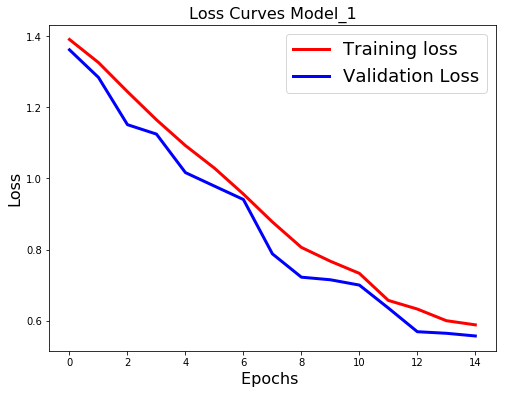

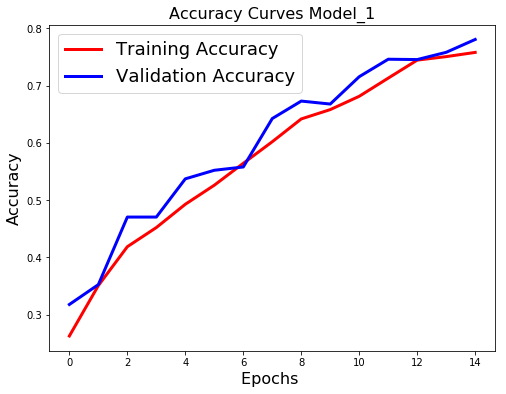

In [7]:
model_name = 'Model_1'
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))
model1.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model1, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.71      0.75      0.73       617
  LYMPHOCYTE       0.94      0.88      0.91       599
    MONOCYTE       0.84      0.93      0.88       621
  NEUTROPHIL       0.76      0.69      0.73       604

   micro avg       0.81      0.81      0.81      2441
   macro avg       0.81      0.81      0.81      2441
weighted avg       0.81      0.81      0.81      2441

Confusion matrix, without normalization
[[462  11  37 107]
 [ 41 526  30   2]
 [ 23   2 576  20]
 [124  19  43 418]]


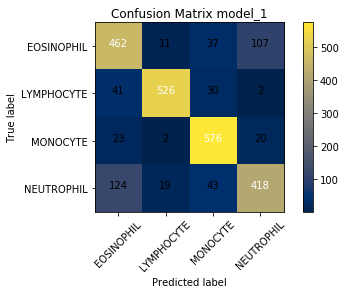

In [8]:
predict(model1 ,'model_1',image_generator,2441,batch_size)

## Model 2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
__________

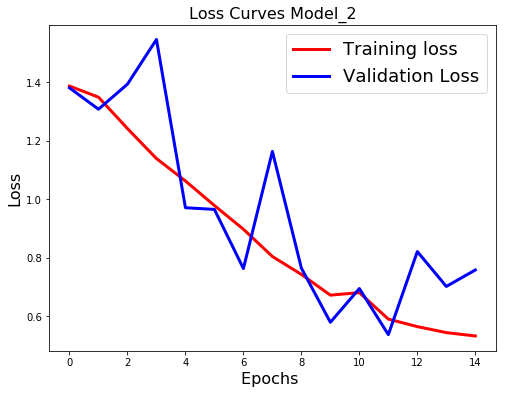

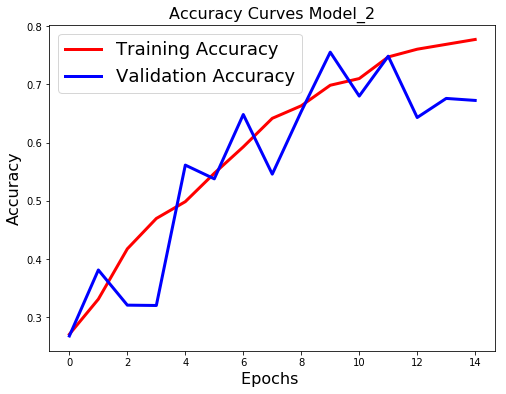

In [9]:
model_name = 'Model_2'
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model2, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.57      0.55      0.56       617
  LYMPHOCYTE       0.89      0.81      0.85       599
    MONOCYTE       0.72      0.85      0.78       621
  NEUTROPHIL       0.57      0.53      0.55       604

   micro avg       0.69      0.69      0.69      2441
   macro avg       0.69      0.69      0.69      2441
weighted avg       0.69      0.69      0.69      2441

Confusion matrix, without normalization
[[342  44  56 175]
 [ 42 487  39  31]
 [ 51   5 527  38]
 [160  10 111 323]]


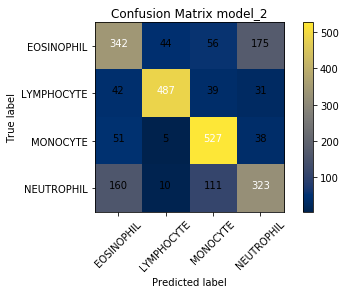

In [10]:
predict(model2 ,'model_2',image_generator,2441,batch_size)

## Model 3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 3, 64)          36928     
__________

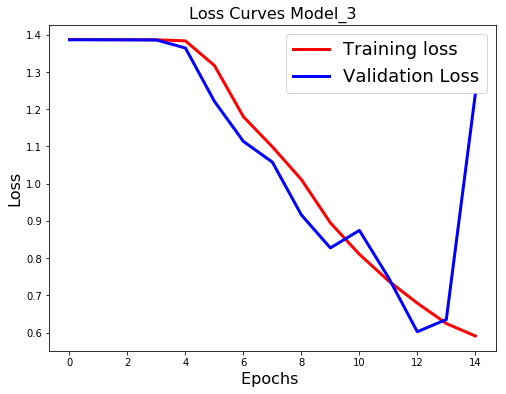

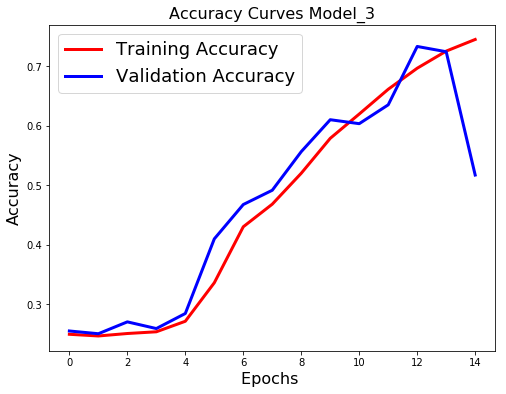

In [11]:
model_name = 'Model_3'
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#extra CRP
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model3.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model3, model_name, image_generator, batch_size, epochs, 10000, 2000)

              precision    recall  f1-score   support

  EOSINOPHIL       0.41      0.79      0.54       617
  LYMPHOCYTE       0.91      0.37      0.53       599
    MONOCYTE       0.81      0.46      0.58       621
  NEUTROPHIL       0.43      0.47      0.45       604

   micro avg       0.52      0.52      0.52      2441
   macro avg       0.64      0.52      0.53      2441
weighted avg       0.64      0.52      0.53      2441

Confusion matrix, without normalization
[[489  22   7  99]
 [283 222  43  51]
 [108   0 284 229]
 [302   0  16 286]]


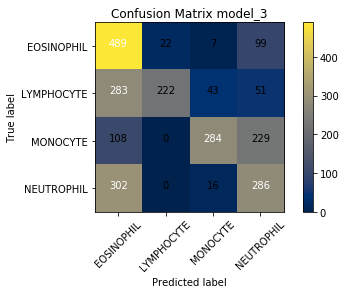

In [12]:
predict(model3 ,'model_3',image_generator,2441,batch_size)

## Model 4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
__________

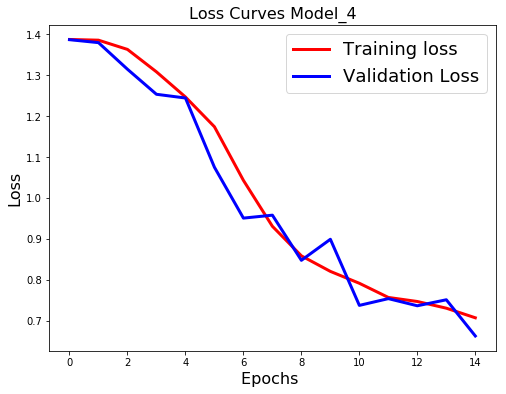

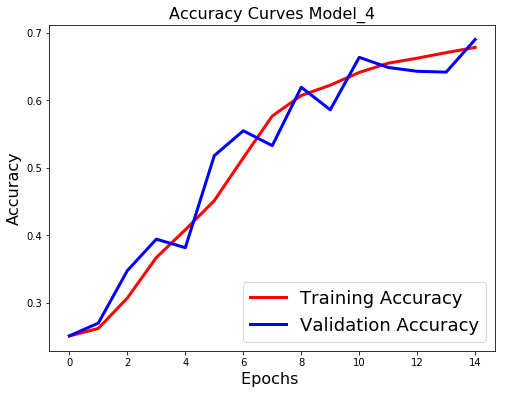

In [13]:
model_name = 'Model_4'
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
#add extra Dense layer
model4.add(Dense(128, activation='relu'))
model4.add(Dense(4, activation='softmax'))
model4.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model4, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.55      0.37      0.44       617
  LYMPHOCYTE       0.81      0.71      0.76       599
    MONOCYTE       0.71      0.74      0.73       621
  NEUTROPHIL       0.51      0.72      0.60       604

   micro avg       0.64      0.64      0.64      2441
   macro avg       0.65      0.64      0.63      2441
weighted avg       0.65      0.64      0.63      2441

Confusion matrix, without normalization
[[227  96  45 249]
 [ 37 426  94  42]
 [ 29   1 462 129]
 [117   5  46 436]]


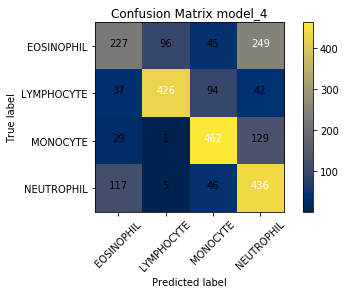

In [14]:
predict(model4 ,'model_4',image_generator,2441,batch_size)

## Model 5

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 78, 58, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 5, 64)          0         
___________________________

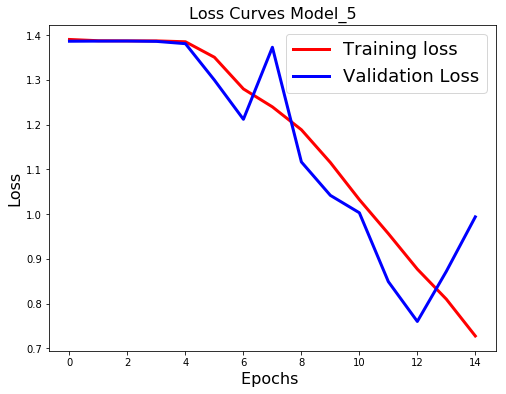

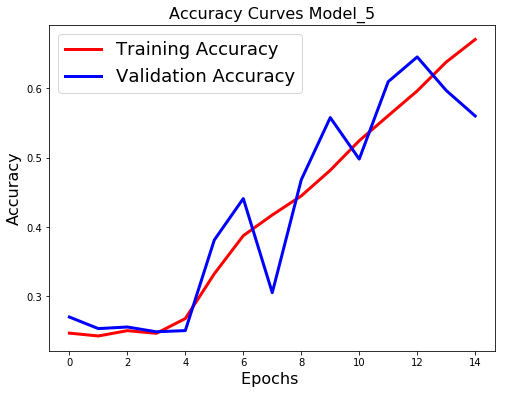

In [15]:
model_name = 'Model_5'
model5 = Sequential()
model5.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=1))
model5.add(MaxPooling2D(pool_size=(2, 2)))


model5.add(Conv2D(32, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))



model5.add(Flatten())
model5.add(Dense(128, activation='relu'))


#add dropout 
model5.add(Dropout(0.5))

model5.add(Dense(4, activation='softmax'))
model5.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(),
                  metrics=['accuracy'])

fit(model5, model_name, image_generator, batch_size, epochs, 7087, 1769)

              precision    recall  f1-score   support

  EOSINOPHIL       0.34      0.42      0.38       617
  LYMPHOCYTE       0.48      0.69      0.56       599
    MONOCYTE       0.72      0.57      0.64       621
  NEUTROPHIL       0.59      0.31      0.41       604

   micro avg       0.50      0.50      0.50      2441
   macro avg       0.53      0.50      0.50      2441
weighted avg       0.53      0.50      0.50      2441

Confusion matrix, without normalization
[[260 260  26  71]
 [ 97 411  88   3]
 [124  83 357  57]
 [280 111  23 190]]


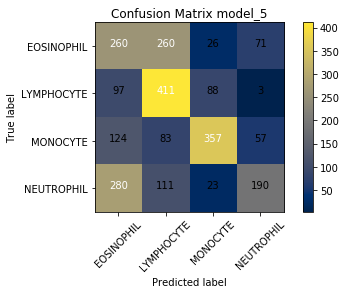

In [16]:
predict(model5 ,'model_5',image_generator,2441,batch_size)